In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV  


In [1]:
#Code for Hyperparameter Tuning
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Ticker', 'Datetime'], inplace=True)

    feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 
                     'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell', 
                    'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell',
                    'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell']
    
    df = df[feature_cols + ['Datetime', 'Ticker']].dropna()
    df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)  # Next period return as target
    df.dropna(inplace=True)
    
    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])
    
    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]
    
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]

# Function to create model for GridSearchCV
def create_lstm_model(input_shape, units_1=128, units_2=64, dropout_rate=0.3, learning_rate=0.0005):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units_1, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units_2, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(LSTM(32, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        Bidirectional(LSTM(units_1, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units_2, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# Hyperparameter tuning using GridSearchCV
def hyperparameter_tuning(X_train, y_train, input_shape):
    model = KerasRegressor(model=create_lstm_model, model__input_shape=input_shape, verbose=0)
    
    param_grid = {
        'model__units_1': [64, 128],
        'model__units_2': [32, 64],
        'model__dropout_rate': [0.3],
        'model__learning_rate': [0.0001, 0.0005],
        'batch_size': [32]
    }
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_result.best_params_}")
    return grid_result.best_params_

# Function to train and evaluate the model
def train_and_evaluate_model(df, feature_cols, ticker):
    df_ticker = df[df['Ticker'] == ticker]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_ticker, feature_cols)

    # Train-test split (first 80% train, last 20% test)
    X_train, X_test, y_train, y_test, dates_test, close_prices_test = split_data(X, y, dates, close_prices)
    
    # Hyperparameter tuning
    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = hyperparameter_tuning(X_train, y_train, input_shape)
    
    model = create_lstm_model(input_shape, **{k.replace('model__', ''): v for k, v in best_params.items() if 'model__' in k})

    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_test, y_test), callbacks=callbacks)

    # Predict and rescale returns
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    return model, y_test, y_pred, dates_test, close_prices_test 

# Function to log trades and calculate cumulative return
def log_trades(dates, actual_returns, predicted_returns, close_prices, ticker):
    positions = ['LONG' if pred > 0 else 'SHORT' for pred in predicted_returns.flatten()]
    cumulative_return = np.cumprod(1 + (actual_returns * (np.array(positions) == 'LONG') - actual_returns * (np.array(positions) == 'SHORT'))) - 1
    
    trades = pd.DataFrame({
        'Date': dates,
        'Stock_Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns,
        'Position': positions,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })
    
    return trades 

# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for ticker in all_trades_df['Ticker'].unique():
        df_ticker = all_trades_df[all_trades_df['Ticker'] == ticker]
        plt.plot(df_ticker['Date'], df_ticker['Cumulative_Return'], label=ticker)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Stock')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


# Load dataset
#file_path = "./data_with_indicators/stock_prices_5m_with_indicators.csv"
#df, feature_cols = load_and_preprocess_data(file_path)

# Loop through each ticker and process data
#all_trades = []
#unique_tickers = df['Ticker'].unique()

#print(f"Processing GOOGL...")
#model, y_test, y_pred, dates_test, close_prices_test = train_and_evaluate_model(df, feature_cols, 'GOOGL')

# Log trades and update cumulative returns
#trades = log_trades(dates_test, y_test.flatten(), y_pred.flatten(), close_prices_test, 'GOOGL')
#all_trades.append(trades)

# Combine all trades into a single DataFrame
#all_trades_df = pd.concat(all_trades, ignore_index=True)

# Plot cumulative returns for all stocks
#plot_cumulative_returns(all_trades_df) 

#Best Parameters AAPL: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0001, 'model__units_1': 128, 'model__units_2': 32}
#Best Parameters NVDA: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0001, 'model__units_1': 64, 'model__units_2': 64} 
#Best Parameters AMZN: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0005, 'model__units_1': 128, 'model__units_2': 32} 
#Best Parameters TSLA: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0001, 'model__units_1': 128, 'model__units_2': 64} 
#Best Parameters MSFT: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0005, 'model__units_1': 64, 'model__units_2': 32}
#Best Parameters META: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0005, 'model__units_1': 64, 'model__units_2': 64} 
#Best Parameters GOOGL: {'batch_size': 32, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.0005, 'model__units_1': 64, 'model__units_2': 32}

Processing AAPL...


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 131ms/step - loss: 1.1222 - mae: 0.7304 - val_loss: 2.1195 - val_mae: 0.9600 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 1.0455 - mae: 0.6834 - val_loss: 2.1583 - val_mae: 0.9703 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 1.0235 - mae: 0.6692 - val_loss: 2.1169 - val_mae: 0.9619 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.0158 - mae: 0.6764 - val_loss: 2.1188 - val_mae: 0.9611 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.0150 - mae: 0.6726 - val_loss: 2.1046 - val_mae: 0.9514 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.0089 - mae: 0.6708 - val_loss: 2.1568 - val_mae: 0.9790 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 1.0070 - mae: 0.6660 - val_loss: 2.1148 - val_mae

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - loss: 1.2174 - mae: 0.7553 - val_loss: 2.2790 - val_mae: 1.0129 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 1.1063 - mae: 0.7061 - val_loss: 2.3080 - val_mae: 1.0228 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - loss: 1.0843 - mae: 0.6959 - val_loss: 2.3243 - val_mae: 1.0282 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - loss: 1.0660 - mae: 0.6881 - val_loss: 2.2563 - val_mae: 1.0047 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - loss: 1.0598 - mae: 0.6891 - val_loss: 2.3201 - val_mae: 1.0263 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - loss: 1.0635 - mae: 0.6829 - val_loss: 2.2578 - val_mae: 1.0051 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - loss: 1.0533 - mae: 0.6798 - val_loss: 2.2560 - va

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 57s 190ms/step - loss: 2.8104 - mae: 0.7911 - val_loss: 2.3509 - val_mae: 0.9174 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - loss: 2.7157 - mae: 0.7489 - val_loss: 2.3581 - val_mae: 0.9163 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - loss: 2.7101 - mae: 0.7377 - val_loss: 2.3485 - val_mae: 0.9163 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - loss: 2.7079 - mae: 0.7426 - val_loss: 2.3574 - val_mae: 0.9228 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - loss: 2.6999 - mae: 0.7339 - val_loss: 2.3478 - val_mae: 0.9184 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - loss: 2.6777 - mae: 0.7238 - val_loss: 2.3432 - val_mae: 0.9163 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - loss: 2.6813 - mae: 0.7295 - val_loss: 2.3458 - v

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 69s 206ms/step - loss: 1.3955 - mae: 0.7938 - val_loss: 2.6931 - val_mae: 1.0004 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 170ms/step - loss: 1.2480 - mae: 0.7309 - val_loss: 2.6859 - val_mae: 1.0002 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - loss: 1.2313 - mae: 0.7085 - val_loss: 2.9821 - val_mae: 1.0880 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 1.2061 - mae: 0.6963 - val_loss: 2.7226 - val_mae: 1.0143 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - loss: 1.1650 - mae: 0.6858 - val_loss: 2.7571 - val_mae: 1.0312 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - loss: 1.1659 - mae: 0.6829 - val_loss: 2.7013 - val_mae: 1.0011 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 179ms/step - loss: 1.1448 - mae: 0.6750 - val_loss: 2.7009 - v

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - loss: 1.4170 - mae: 0.7952 - val_loss: 2.0850 - val_mae: 0.9746 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.2250 - mae: 0.6889 - val_loss: 2.0922 - val_mae: 0.9779 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.1975 - mae: 0.6771 - val_loss: 2.0893 - val_mae: 0.9740 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.2023 - mae: 0.6779 - val_loss: 2.0842 - val_mae: 0.9746 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.1889 - mae: 0.6717 - val_loss: 2.0863 - val_mae: 0.9750 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.1844 - mae: 0.6715 - val_loss: 2.0819 - val_mae: 0.9726 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.1858 - mae: 0.6719 - val_loss: 2.0873 - val_mae:

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 1.5312 - mae: 0.7684 - val_loss: 2.0703 - val_mae: 0.9052 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.4706 - mae: 0.7417 - val_loss: 2.0580 - val_mae: 0.9073 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.4478 - mae: 0.7255 - val_loss: 2.0620 - val_mae: 0.9080 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.4281 - mae: 0.7193 - val_loss: 2.0851 - val_mae: 0.9114 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.4207 - mae: 0.7087 - val_loss: 2.0794 - val_mae: 0.9197 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.4280 - mae: 0.7193 - val_loss: 2.0673 - val_mae: 0.9049 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.4145 - mae: 0.7147 - val_loss: 2.0696 - val_mae: 

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 1.1129 - mae: 0.7057 - val_loss: 2.4279 - val_mae: 0.9614 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.0384 - mae: 0.6662 - val_loss: 2.4271 - val_mae: 0.9613 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.0298 - mae: 0.6583 - val_loss: 2.4271 - val_mae: 0.9613 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.0363 - mae: 0.6636 - val_loss: 2.4271 - val_mae: 0.9613 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 1.0297 - mae: 0.6574 - val_loss: 2.4271 - val_mae: 0.9613 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.0278 - mae: 0.6563 - val_loss: 2.4271 - val_mae: 0.9613 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.0283 - mae: 0.6589 - val_loss: 2.4271 - val_mae:

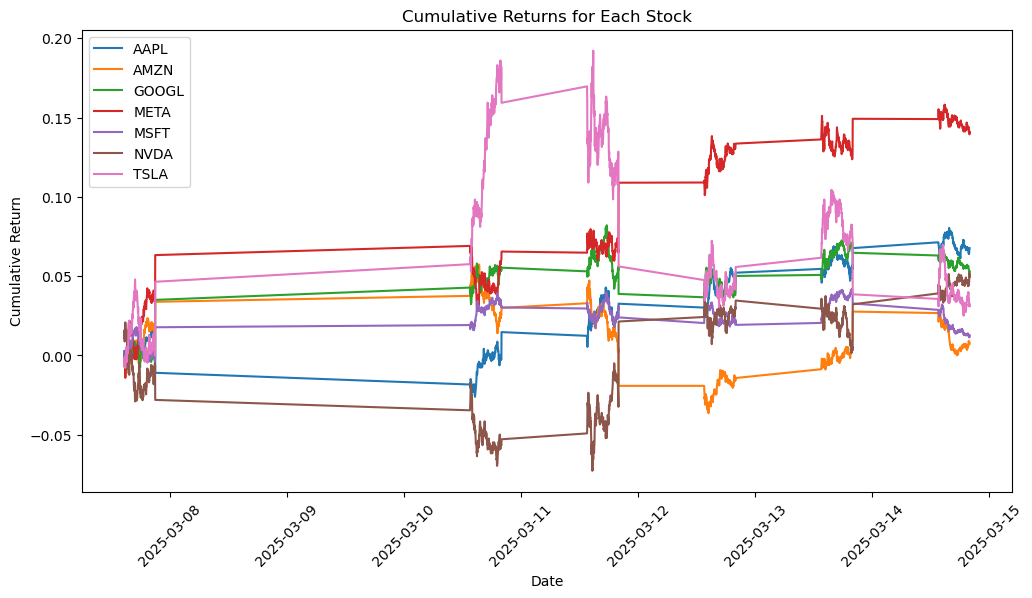

In [10]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.config.experimental.enable_op_determinism() 

def load_and_preprocess_data(file_path, sentiment_path=None):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Ticker', 'Datetime'], inplace=True)

    feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell',
                    'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 
                    'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell']

    df = df[feature_cols + ['Datetime', 'Ticker']].dropna()

    # ✅ Merge daily sentiment with intraday stock data
    if sentiment_path:
        sentiment = pd.read_csv(sentiment_path)
        sentiment.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
        sentiment['Date'] = pd.to_datetime(sentiment['Date'])

        # Convert from wide to long format: Date | Ticker | Sentiment
        sentiment = sentiment.melt(id_vars='Date', var_name='Ticker', value_name='Sentiment')
        sentiment['Date'] = sentiment['Date'].dt.normalize()
        sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)

        # Normalize stock datetime to just date
        df['Date'] = df['Datetime'].dt.normalize()
        df['Date'] = df['Date'].dt.tz_localize(None)

        # Merge to broadcast daily sentiment across all minutes of the day
        df = pd.merge(df, sentiment, how='left', on=['Date', 'Ticker'])
        df.drop(columns='Date', inplace=True)

        df['Sentiment'] = df['Sentiment'].fillna(0)
        feature_cols.append('Sentiment')

    # Compute next-period return (target)
    df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
    df.dropna(inplace=True)

    return df, feature_cols



# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]

# Define the improved LSTM model
def improved_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='tanh')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='mse',
                  metrics=['mae'])
    return model


# Train and evaluate the model
def train_and_evaluate_model(df, feature_cols, ticker):
    df_ticker = df[df['Ticker'] == ticker]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_ticker, feature_cols)
    
    X_train, X_test, y_train, y_test, dates_test, close_prices_test = split_data(X, y, dates, close_prices)
    model = improved_lstm_model((X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
    
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)
    
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test = return_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    return model, y_test, y_pred, dates_test, close_prices_test

def log_trades(dates, actual_returns, predicted_returns, close_prices, ticker):
    positions = np.where(predicted_returns.flatten() > 0, 'LONG', 'SHORT')

    fee = 2.838e-4  # Trading fee (0.02838%)
    strategy_returns = np.zeros_like(actual_returns.flatten())

    prev_position = None
    for i in range(len(actual_returns)):
        curr_position = positions[i]

        # Determine base return based on position
        if curr_position == 'LONG':
            ret = actual_returns[i]
        elif curr_position == 'SHORT':
            ret = -actual_returns[i]
        else:
            ret = 0

        # Apply fee only if position changed
        if prev_position is not None and curr_position != prev_position:
            ret -= fee

        strategy_returns[i] = ret
        prev_position = curr_position

    # Compute cumulative return
    cumulative_return = np.cumprod(1 + strategy_returns) - 1

    trades = pd.DataFrame({
        'Date': dates,
        'Stock_Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns.flatten(),
        'Position': positions,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })

    # Ensure proper formatting and volatility computation
    trades['Date'] = pd.to_datetime(trades['Date'])
    trades = trades.sort_values('Date').reset_index(drop=True)
    trades['Rolling_STD_Return'] = trades['Cumulative_Return'].rolling(window=5).std()

    return trades

# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for ticker in all_trades_df['Ticker'].unique():
        df_ticker = all_trades_df[all_trades_df['Ticker'] == ticker]
        plt.plot(df_ticker['Date'], df_ticker['Cumulative_Return'], label=ticker)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Stock')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


# Load dataset
file_path = "./data_with_indicators/stock_prices_2m_with_indicators.csv"
sentiment_file_path = "aggregated_daily_sentiment.csv"
df, feature_cols = load_and_preprocess_data(file_path, sentiment_file_path)

# Loop through each ticker and process data
all_trades = []
unique_tickers = df['Ticker'].unique()

for ticker in unique_tickers:
    print(f"Processing {ticker}...")
    model, y_test, y_pred, dates_test, close_prices_test = train_and_evaluate_model(df, feature_cols, ticker)
    
    # Log trades and update cumulative returns
    trades = log_trades(dates_test, y_test.flatten(), y_pred.flatten(), close_prices_test, ticker)
    all_trades.append(trades)

# Combine all trades into a single DataFrame
all_trades_df = pd.concat(all_trades, ignore_index=True) 


# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_df)
 


In [11]:
print(all_trades_df) 


                    Date  Stock_Close_Price  Predicted_Return  Actual_Return  \
0    2025-03-07 14:36:00         236.680603          0.000068       0.002659   
1    2025-03-07 14:38:00         237.309998         -0.000119       0.003203   
2    2025-03-07 14:40:00         238.070007         -0.000119       0.000630   
3    2025-03-07 14:42:00         238.220001          0.000005       0.000357   
4    2025-03-07 14:44:00         238.304993          0.000105      -0.000021   
...                  ...                ...               ...            ...   
8156 2025-03-14 19:48:00         248.729996         -0.000050       0.001045   
8157 2025-03-14 19:50:00         248.990005         -0.000050       0.003708   
8158 2025-03-14 19:52:00         249.913193         -0.000050      -0.001453   
8159 2025-03-14 19:54:00         249.550003         -0.000050       0.001843   
8160 2025-03-14 19:56:00         250.009995         -0.000050      -0.000118   

     Position  Cumulative_Return Ticker

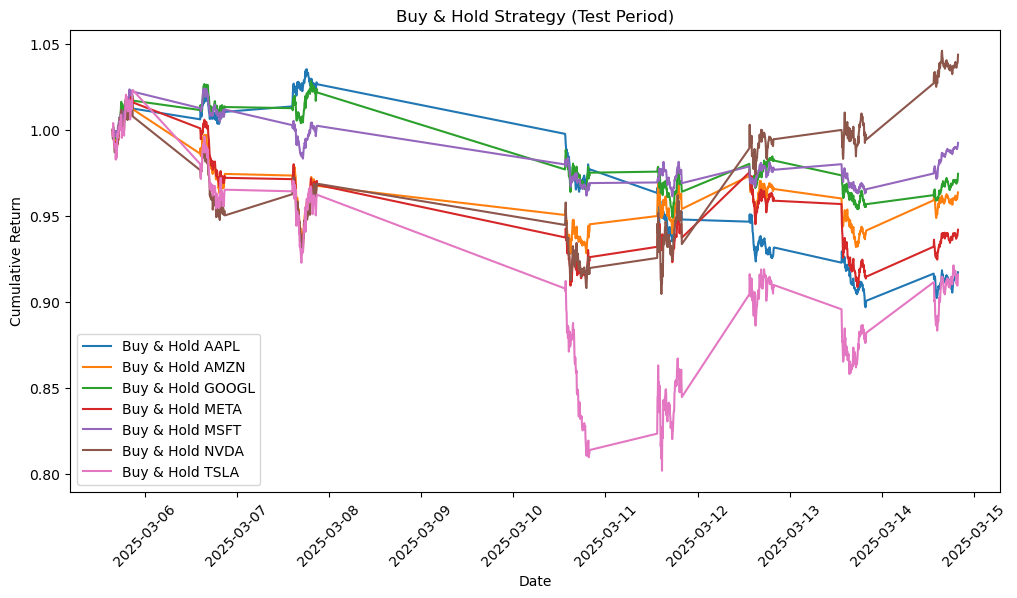

In [12]:
# Reload the dataset
file_path = "./data_with_indicators/stock_prices_5m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Function to plot Buy & Hold strategy for the test period (last 20% of the dataset)
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(12, 6))

    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        initial_price = df_test['Close'].iloc[0]
        buy_and_hold_returns = df_test['Close'] / initial_price  # Normalize returns

        plt.plot(df_test['Datetime'], buy_and_hold_returns, label=f'Buy & Hold {ticker}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Strategy (Test Period)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Plot the Buy & Hold strategy for the test period
plot_buy_and_hold_test_period(df) 

In [13]:
# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns(df, all_trades_df):
    results = []

    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Ticker": ticker,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_df' in globals():
    strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")

  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0   AAPL                  -8.29                         6.76
1   AMZN                  -3.64                         0.73
2  GOOGL                  -2.56                         5.30
3   META                  -5.81                        14.09
4   MSFT                  -0.76                         1.27
5   NVDA                   4.37                         4.95
6   TSLA                  -8.41                         3.10


In [ ]:
#5 mins
#Learning Rate = 0.0005 
# Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                         4.32
#1   AMZN                  -3.64                         6.59
#2  GOOGL                  -2.56                         3.38
#3   META                  -5.81                         2.39
#4   MSFT                  -0.76                         2.08
#5   NVDA                   4.37                        15.02
#6   TSLA                  -8.41                        21.81 

#2 mins
#Learning Rate = 0.0005 
#Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                         2.82
#1   AMZN                  -3.64                         0.53
#2  GOOGL                  -2.56                         3.61
#3   META                  -5.81                        11.11
#4   MSFT                  -0.76                        12.19
#5   NVDA                   4.37                        15.64
#6   TSLA                  -8.41                        11.25 

#15mins  
#Learning Rate = 0.0005 
#Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                        -7.01
#1   AMZN                  -3.64                        -2.30
#2  GOOGL                  -2.56                         7.92
#3   META                  -5.81                         9.37
#4   MSFT                  -0.76                        -0.22
#5   NVDA                   4.37                         4.17
#6   TSLA                  -8.41                         3.30

In [ ]:
#5 mins
#Learning Rate = 0.001 
#  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                        -1.83
#1   AMZN                  -3.64                         0.78
#2  GOOGL                  -2.56                        13.21
#3   META                  -5.81                        27.47
#4   MSFT                  -0.76                         3.77
#5   NVDA                   4.37                         3.76
#6   TSLA                  -8.41                        15.52

#2 mins
#Learning Rate = 0.001 
#  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -9.22                        13.01
#1   AMZN                  -1.28                         0.53
#2  GOOGL                  -3.41                         3.61
#3   META                  -3.12                         3.64
#4   MSFT                  -2.04                        -0.58
#5   NVDA                  10.06                        36.76
#6   TSLA                  -5.09                         3.10

#15mins  
#Learning Rate = 0.001 
#  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                        11.39
#1   AMZN                  -3.64                        17.40
#2  GOOGL                  -2.56                         8.33
#3   META                  -5.81                         7.58
#4   MSFT                  -0.76                        -0.62
#5   NVDA                   4.37                        -5.57
#6   TSLA                  -8.41                         4.62

In [ ]:
#5 mins
#Learning Rate = 0.0001 
#  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                         3.91
#1   AMZN                  -3.64                        -3.68
#2  GOOGL                  -2.56                         4.40
#3   META                  -5.81                        11.46
#4   MSFT                  -0.76                         7.23
#5   NVDA                   4.37                       -23.55
#6   TSLA                  -8.41                         4.71 

#2 mins
#Learning Rate = 0.0001 
#  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.29                         2.42
#1   AMZN                  -3.64                        13.15
#2  GOOGL                  -2.56                         2.66
#3   META                  -5.81                        10.10
#4   MSFT                  -0.76                         0.86
#5   NVDA                   4.37                        -7.85
#6   TSLA                  -8.41                        18.13

#15mins  
#Learning Rate = 0.0001 
#  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
#0   AAPL                  -8.54                         7.56
#1   AMZN                  -3.93                        -3.08
#2  GOOGL                  -3.10                         1.93
#3   META                  -6.17                        16.56
#5   NVDA                   3.86                         5.93
#6   TSLA                  -9.06                         4.62